# Telco Customer Churn - Modeling


## 1. Import Libraries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score,precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

# Plot Style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Processed Data

In [4]:
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Seperate features and target
target = 'Churn'
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

Train shape: (5634, 50)
Test shape: (1409, 50)


In [5]:
# --- Input/Output Data Inspection ---
print("Shape of Training Features (X_train):", X_train.shape)
print("Shape of Training Target (y_train):", y_train.shape)
print("Shape of Test Features (X_test):", X_test.shape)
print("Shape of Test Target (y_test):", y_test.shape)

print("\nFirst 5 rows of Input Features:")
display(X_train.head())

print("\nFirst 5 rows of Target Labels (0 = No Churn, 1 = Churn):")
display(y_train.head())

Shape of Training Features (X_train): (5634, 49)
Shape of Training Target (y_train): (5634,)
Shape of Test Features (X_test): (1409, 49)
Shape of Test Target (y_test): (1409,)

First 5 rows of Input Features:


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureCategory_Established,TenureCategory_Loyal,TenureCategory_New
0,0.102371,-0.521976,-0.262257,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,-0.711743,0.337478,-0.503635,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,-0.793155,-0.809013,-0.749883,0,1,1,0,0,1,0,...,1,1,0,0,0,0,1,1,0,0
3,-0.263980,0.284384,-0.172722,1,0,1,0,0,1,1,...,1,0,1,0,1,0,0,1,0,0
4,-1.281624,-0.676279,-0.989374,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1



First 5 rows of Target Labels (0 = No Churn, 1 = Churn):


0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

## 3. Class Imbalance Handling 
Applied **SMOTE** once to the training set to create a balanced dataset for all models

Original Class Distribution: Counter({0: 4139, 1: 1495})
Resampled Class Distribution: Counter({0: 4139, 1: 4139})


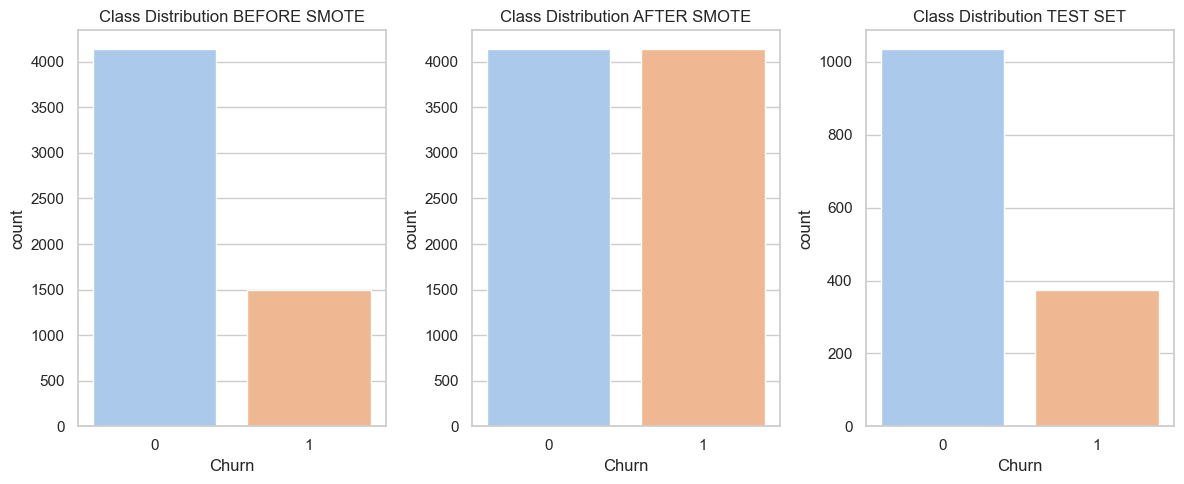

In [6]:
# --- 3. Unified SMOTE Application ---
print("Original Class Distribution:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Class Distribution:", Counter(y_train_resampled))

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=y_train, palette='pastel')
plt.title('Class Distribution BEFORE SMOTE')
plt.subplot(1, 3, 2)
sns.countplot(x=y_train_resampled, palette='pastel')
plt.title('Class Distribution AFTER SMOTE')
plt.subplot(1, 3, 3)
sns.countplot(x=y_test, palette='pastel')
plt.title('Class Distribution TEST SET')
plt.tight_layout()
plt.savefig('../artifacts/images/smote_class_distribution.png')
plt.show()

## 5. Baseline Models
Train and **evaluate** Baselines to establish a benchmark.

#### --- 5.1 Baseline Decision Tree ---


--- Baseline Decision Tree Results ---
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1035
           1       0.49      0.58      0.53       374

    accuracy                           0.73      1409
   macro avg       0.66      0.68      0.67      1409
weighted avg       0.74      0.73      0.73      1409



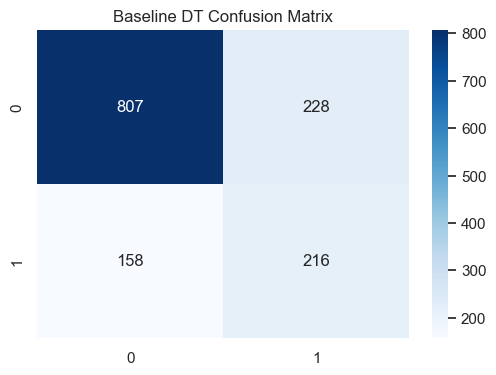

In [7]:
# --- 5.1 Baseline Decision Tree ---
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_resampled, y_train_resampled)

print("\n--- Baseline Decision Tree Results ---")
y_pred_dt_base = dt_baseline.predict(X_test)
print(classification_report(y_test, y_pred_dt_base))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt_base), annot=True, fmt='d', cmap='Blues')
plt.title('Baseline DT Confusion Matrix')
plt.savefig('../artifacts/images/cm_dt_baseline.png')
plt.show()

## 6. Deep Model Optimization
### 6.1 Decision Tree: Extensive Grid Search & Pruning


In [8]:
# 1. Find alphas
clf_base = DecisionTreeClassifier(random_state=42)
path = clf_base.cost_complexity_pruning_path(X_train_resampled, y_train_resampled)
ccp_alphas = path.ccp_alphas[path.ccp_alphas >= 0]

# 2. Define Parameter Grid
print("Running Grid Search for Decision Tree...")
param_grid_dt = {
    'ccp_alpha': list(ccp_alphas[::20]),
    'max_depth': [None, 10, 20, 30, None],
    'min_samples_leaf': [1, 5, 10, 15, 20, None],
    'criterion': ['gini', 'entropy', 'log_loss'], 
    
}

# Stratified K-Fold CV
cvd = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search 
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=cvd, scoring='accuracy', n_jobs=-1, verbose=1)
grid_dt.fit(X_train_resampled, y_train_resampled)
best_dt = grid_dt.best_estimator_

print(f"Best DT F1: {grid_dt.best_score_:.4f}")
print(f"Best DT Params: {grid_dt.best_params_}")

# param_grid_dt = {
#     'ccp_alpha': list(ccp_alphas[::20]),
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 5, 10],
#     'criterion': ['gini', 'entropy']
# }


Running Grid Search for Decision Tree...
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best DT F1: 0.8090
Best DT Params: {'ccp_alpha': np.float64(0.00019328340178787143), 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}


### 6.4 Threshold Optimization
Optimize the classification threshold to maximize the F1-Score.
Since the dataset might still have imbalance characteristics in the test set, shifting the threshold often improves recall significantly.

In [9]:
# --- 6.4 Threshold Tuning ---

def find_optimal_threshold(y_true, y_probs, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    max_f1 = f1_scores[best_idx]

    print(f"{model_name} -> Best Threshold: {best_thresh:.4f}, Max F1: {max_f1:.4f}")

    # Plot F1 vs Threshold

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
    plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Thresh={best_thresh:.2f}')
    plt.title(f'{model_name}: Threshold Optimization')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig(f'../artifacts/images/{model_name}_threshold_tuning.png')
    plt.show()

    return best_thresh

# Get Probabilities
y_probs_dt = best_dt.predict_proba(X_test)[:, 1]
y_probs_nn = model_best.predict(X_test_scaled).flatten()

best_thresh_dt = find_optimal_threshold(y_test, y_probs_dt, "Decision Tree")
best_thresh_nn = find_optimal_threshold(y_test, y_probs_nn, "Neural Network")

NameError: name 'model_best' is not defined

## 7. Visualization & Model Interpretation

### --- 7.1 Feature Importance (Decision Tree) ---

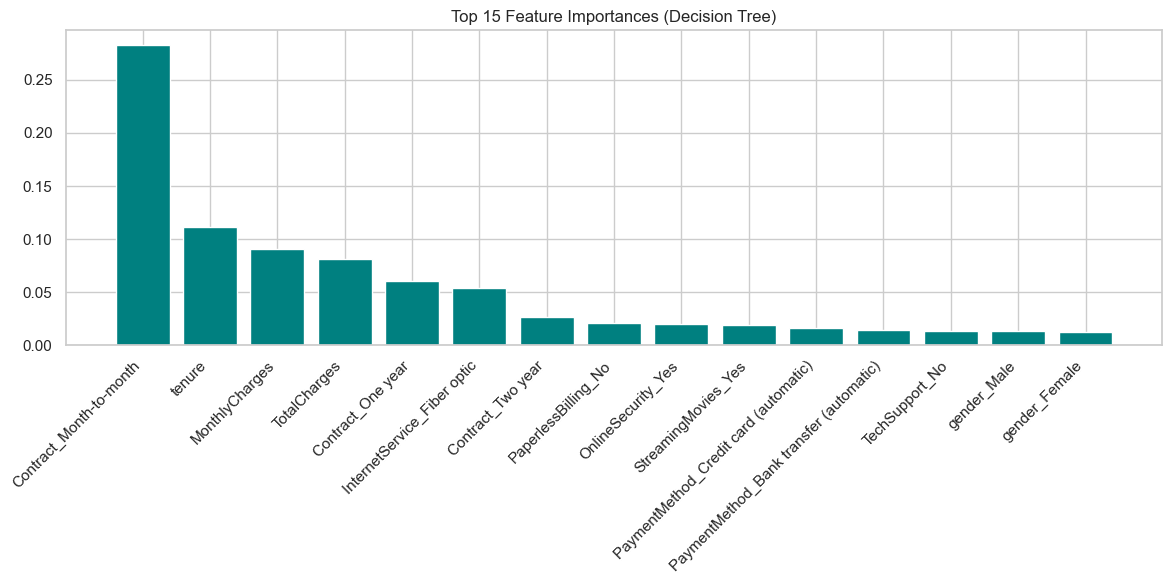

In [ ]:
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(12, 6))
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.bar(range(top_n), importances[indices[:top_n]], align='center', color='teal')
plt.xticks(range(top_n), X_train.columns[indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../artifacts/images/feature_importance_dt.png')
plt.show()



### --- 7.2 Tree Visualization ---

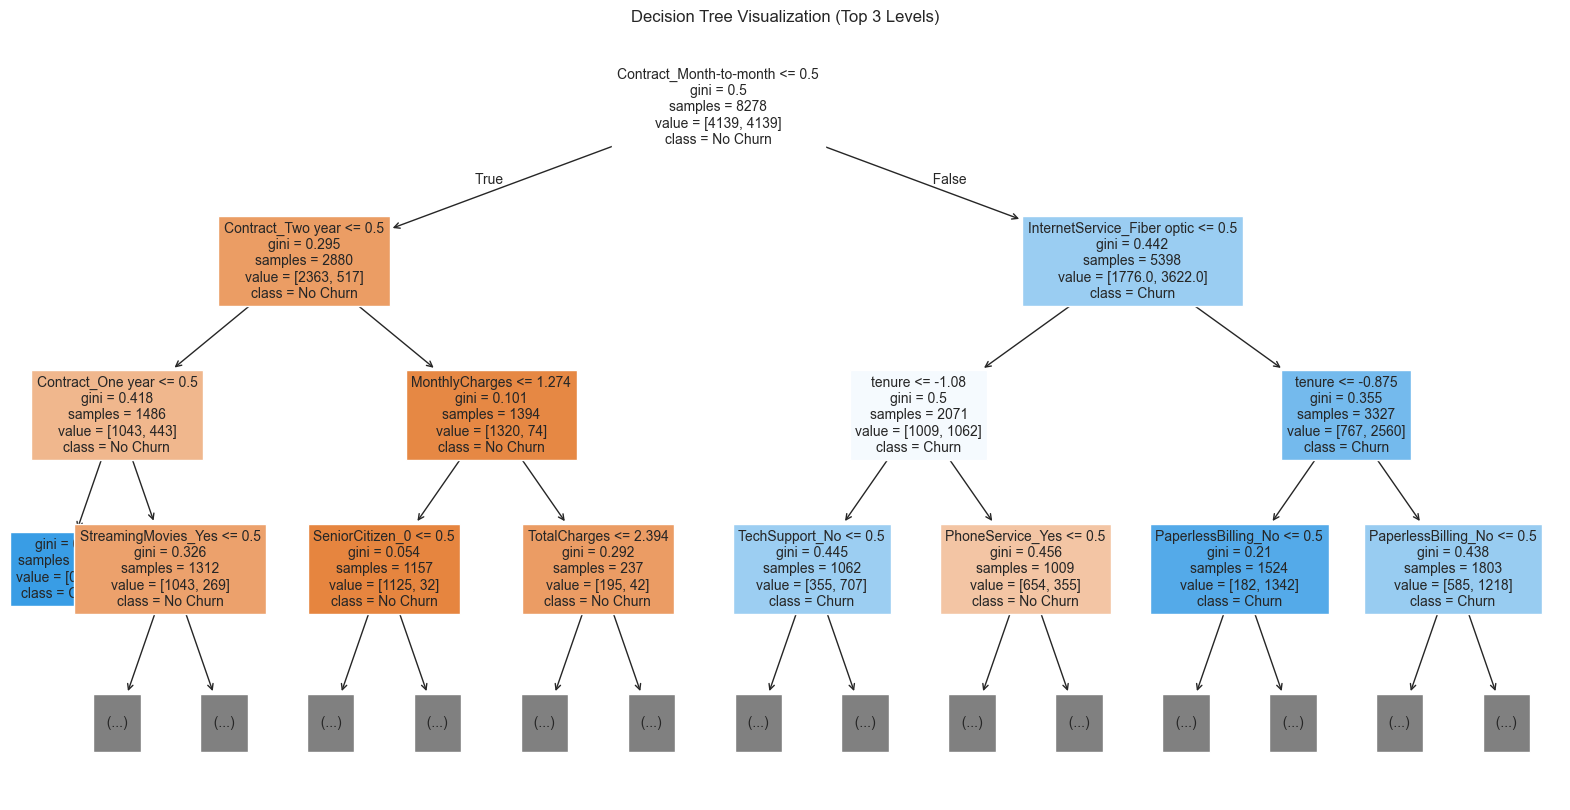

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], filled=True, max_depth=3, fontsize=10)
plt.title('Decision Tree Visualization (Top 3 Levels)')
plt.savefig('images/tree_visualization.png')
plt.show()

## 8. Final Comparative Evaluation (With Optimal Thresholds)

### 8.1 Predictions with Optimal Thresholds

In [ ]:

y_pred_dt_opt = (y_probs_dt >= best_thresh_dt).astype(int)
y_pred_nn_opt = (y_probs_nn >= best_thresh_nn).astype(int)

print("\n--- Optimized Decision Tree (Tuned Threshold) ---")
print(classification_report(y_test, y_pred_dt_opt))

print("\n--- Optimized Neural Network (Tuned Threshold) ---")
print(classification_report(y_test, y_pred_nn_opt))


--- Optimized Decision Tree (Tuned Threshold) ---
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1035
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.73      0.74      1409


--- Optimized Neural Network (Tuned Threshold) ---
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



### 8.2 Final Confusion Matrices

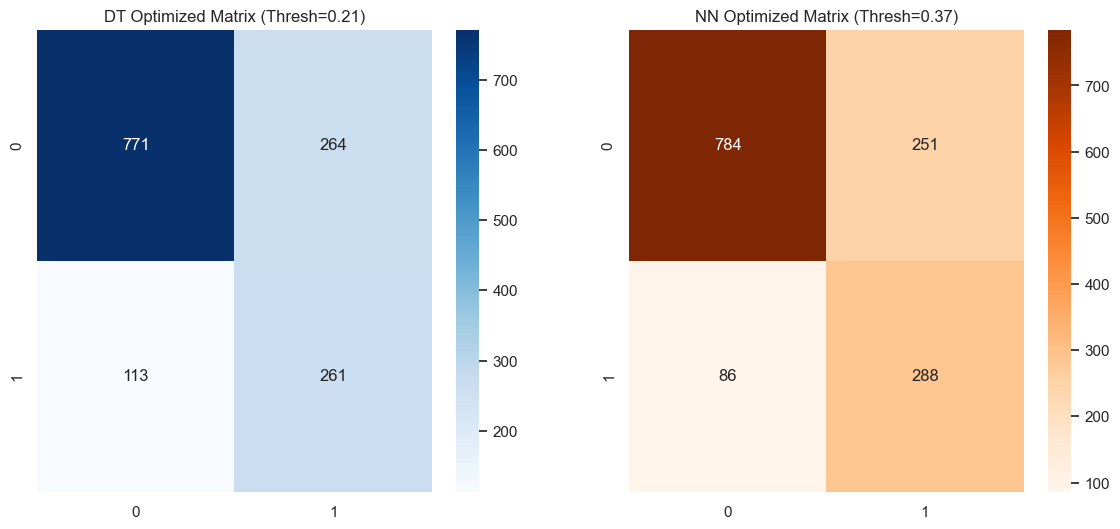

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt_opt), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'DT Optimized Matrix (Thresh={best_thresh_dt:.2f})')
sns.heatmap(confusion_matrix(y_test, y_pred_nn_opt), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title(f'NN Optimized Matrix (Thresh={best_thresh_nn:.2f})')
plt.savefig('../artifacts/images/cm_dt_optimized.png')
plt.show()

#### 8.3 Optimized Models Evaluation 

In [ ]:
print("\n--- Optimized Decision Tree (Tuned Threshold) ---")
print("F1 Score:", f1_score(y_test, y_pred_dt_opt))
print("Precision:", precision_score(y_test, y_pred_dt_opt))
print("Recall:", recall_score(y_test, y_pred_dt_opt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt_opt))

print("\n--- Optimized Neural Network (Tuned Threshold) ---")
print("F1 Score:", f1_score(y_test, y_pred_nn_opt))
print("Precision:", precision_score(y_test, y_pred_nn_opt))
print("Recall:", recall_score(y_test, y_pred_nn_opt))
print("Accuracy:", accuracy_score(y_test, y_pred_nn_opt))


--- Optimized Decision Tree (Tuned Threshold) ---
F1 Score: 0.5806451612903226
Precision: 0.49714285714285716
Recall: 0.6978609625668449
Accuracy: 0.7324343506032647

--- Optimized Neural Network (Tuned Threshold) ---
F1 Score: 0.6308871851040526
Precision: 0.5343228200371057
Recall: 0.7700534759358288
Accuracy: 0.7608232789212207


### 8.4 Combined ROC Curves


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


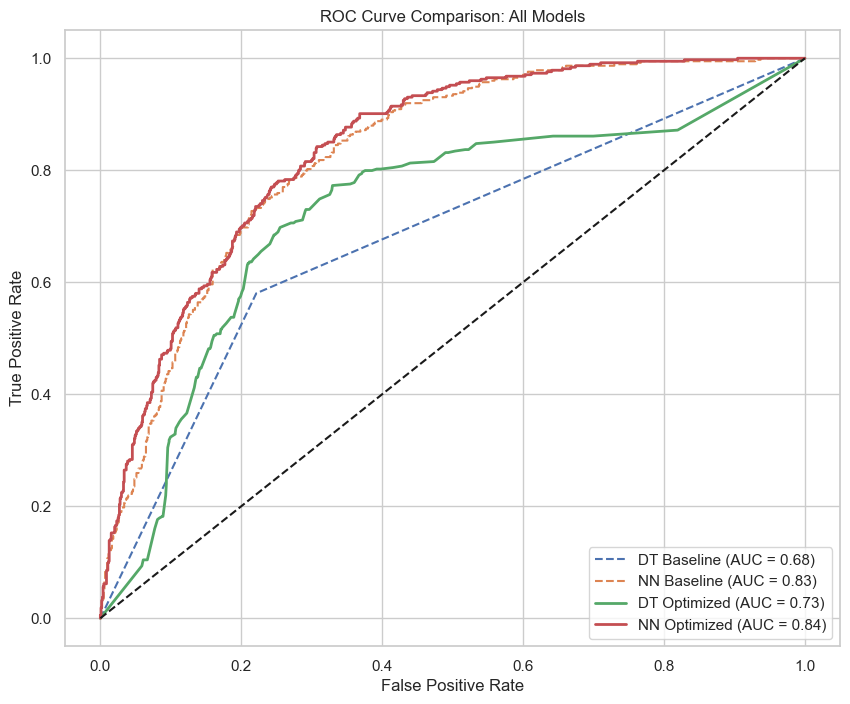

In [ ]:
plt.figure(figsize=(10, 8))
# Baselines
y_probs_dt_base = dt_baseline.predict_proba(X_test)[:, 1]
y_probs_nn_base = nn_baseline.predict(X_test_scaled).flatten()

fpr_dt_b, tpr_dt_b, _ = roc_curve(y_test, y_probs_dt_base)
fpr_nn_b, tpr_nn_b, _ = roc_curve(y_test, y_probs_nn_base)
roc_auc_dt_b = roc_auc_score(y_test, y_probs_dt_base)
roc_auc_nn_b = roc_auc_score(y_test, y_probs_nn_base)

# Optimized
fpr_dt_o, tpr_dt_o, _ = roc_curve(y_test, y_probs_dt)
fpr_nn_o, tpr_nn_o, _ = roc_curve(y_test, y_probs_nn)
roc_auc_dt_o = roc_auc_score(y_test, y_probs_dt)
roc_auc_nn_o = roc_auc_score(y_test, y_probs_nn)

plt.plot(fpr_dt_b, tpr_dt_b, label=f'DT Baseline (AUC = {roc_auc_dt_b:.2f})', linestyle='--')
plt.plot(fpr_nn_b, tpr_nn_b, label=f'NN Baseline (AUC = {roc_auc_nn_b:.2f})', linestyle='--')
plt.plot(fpr_dt_o, tpr_dt_o, label=f'DT Optimized (AUC = {roc_auc_dt_o:.2f})', linewidth=2)
plt.plot(fpr_nn_o, tpr_nn_o, label=f'NN Optimized (AUC = {roc_auc_nn_o:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc='lower right')
plt.savefig('../artifacts/images/roc_curve_comparison.png')
plt.show()

### 8.5 Before vs After Comparison Graph

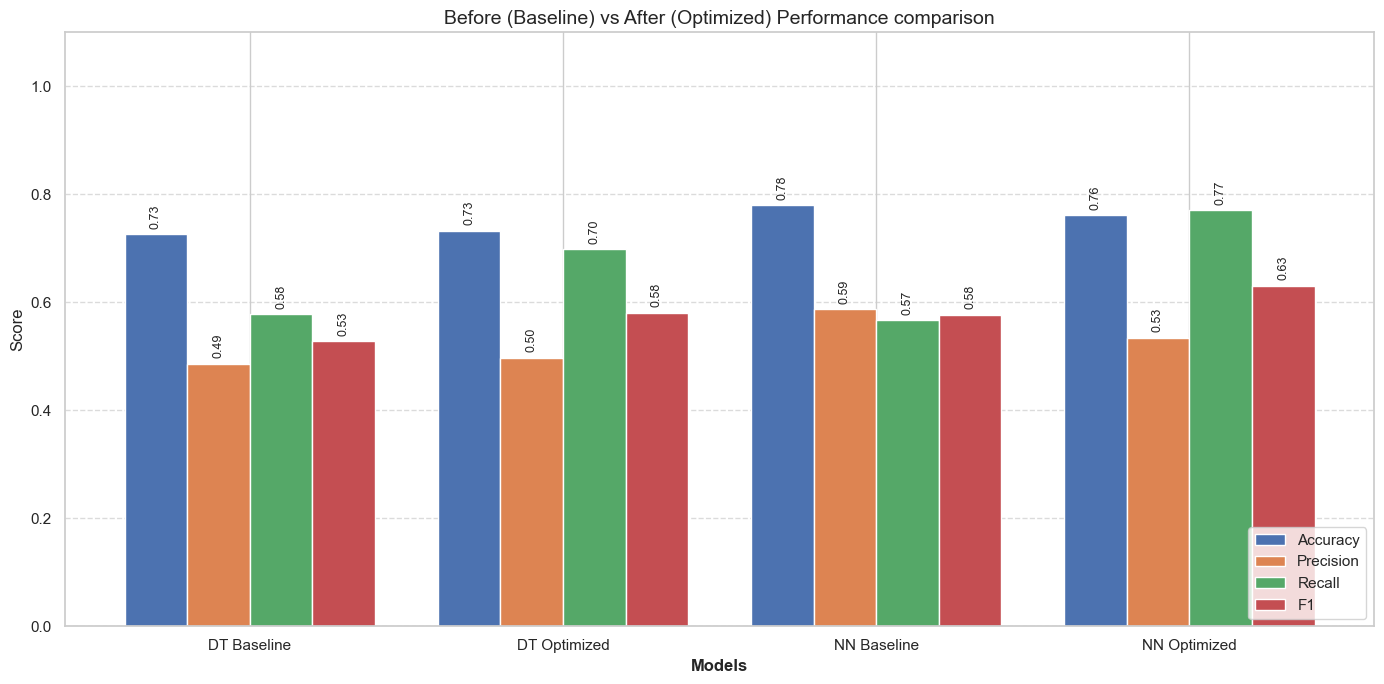

In [ ]:
# 1. Define Helper to get metrics
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# 2. Baseline Metrics
# y_pred_dt_base and y_pred_nn_base were defined in Section 5
metrics_dt_base = get_metrics(y_test, y_pred_dt_base)
metrics_nn_base = get_metrics(y_test, y_pred_nn_base)

# 3. Optimized Metrics (Apply Thresholds)
y_pred_dt_opt = (y_probs_dt >= best_thresh_dt).astype(int)
y_pred_nn_opt = (y_probs_nn >= best_thresh_nn).astype(int)

metrics_dt_opt = get_metrics(y_test, y_pred_dt_opt)
metrics_nn_opt = get_metrics(y_test, y_pred_nn_opt)

# 4. Organize Data
models = ['DT Baseline', 'DT Optimized', 'NN Baseline', 'NN Optimized']
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1']

data = {m: [] for m in metrics_list}
for metric_set in [metrics_dt_base, metrics_dt_opt, metrics_nn_base, metrics_nn_opt]:
    for m in metrics_list:
        data[m].append(metric_set[m])

# 5. Plotting
x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(14, 7))

for i, metric in enumerate(metrics_list):
    plt.bar(x + i*width, data[metric], width, label=metric)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score')
plt.title('Before (Baseline) vs After (Optimized) Performance comparison', fontsize=14)
plt.xticks(x + 1.5*width, models)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, metric in enumerate(metrics_list):
    for j, val in enumerate(data[metric]):
        plt.text(x[j] + i*width, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.savefig('../artifacts/images/before_after_comparison.png')
plt.show()